In [1]:
import pandas as pd

## import data

In [2]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')

In [5]:
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')

In [9]:
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')

In [12]:
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

## process data

In [20]:
hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')#.assign(ratio=F/T)

sex,F,T
geo,,
AT,899.6,1796.1
BA,159.6,312.9
BE,1086.9,2065.6
BG,479.8,824.3
CH,1011.8,2048.5
CY,90.5,170.8
CZ,892.7,1812.6
DE,9415.9,18139.5
DK,703.3,1399.9


<Axes: >

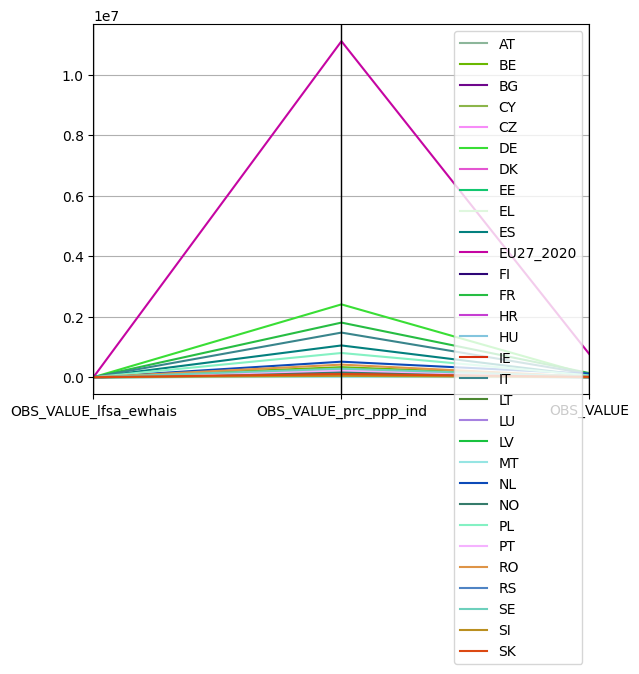

In [29]:
pd.plotting.parallel_coordinates(
(lfsa_ewhais
 .set_index('geo')
 [['OBS_VALUE']]
 .merge(prc_ppp_ind
        .set_index('geo')
        [['OBS_VALUE']],
        left_index=True, 
        right_index=True,
        suffixes=('_lfsa_ewhais', '_prc_ppp_ind')
       )
 .merge(sbs_ovw_act
        .set_index('geo')
        [['OBS_VALUE']],
        left_index=True, 
        right_index=True,
        suffixes=('', '_sbs_ovw_act')
       )
).reset_index()
,'geo'                               )

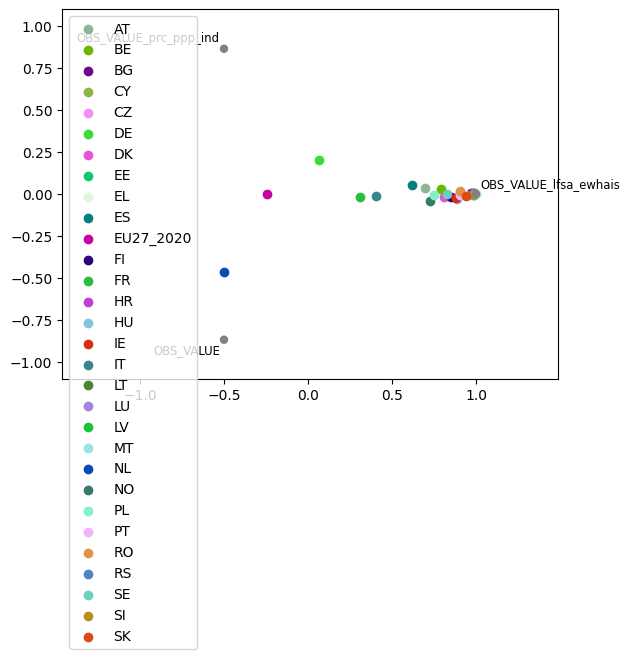

In [31]:
pd.plotting.radviz(
(lfsa_ewhais
 .set_index('geo')
 [['OBS_VALUE']]
 .merge(prc_ppp_ind
        .set_index('geo')
        [['OBS_VALUE']],
        left_index=True, 
        right_index=True,
        suffixes=('_lfsa_ewhais', '_prc_ppp_ind')
       )
 .merge(sbs_ovw_act
        .set_index('geo')
        [['OBS_VALUE']],
        left_index=True, 
        right_index=True,
        suffixes=('', '_sbs_ovw_act')
       )
).reset_index()
,'geo'                               ).legend()